In [125]:
#!pip install openai faiss-cpu

In [ ]:

import boto3
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from openai import OpenAI
import numpy as np
import faiss


### Cargue desde S3

In [ ]:
ACCESS_KEY = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX" ## Reemplazar el Access Key aquí
SECRET_KEY = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX" ## Reemplazar el Secret Key aquí
REGION     = "us-east-2"

session = boto3.Session(
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    region_name=REGION
)

s3 = session.client("s3")
BUCKET_NAME = "amzn-s3-"
OBJECT_KEY  = "transactions_full.csv"


In [3]:
response = s3.get_object(Bucket=BUCKET_NAME, Key=OBJECT_KEY)

In [4]:
df = pd.read_csv(response["Body"])

### Inicio de EDA

In [5]:
df

,user_id,product_id,product_title,product_description,rating,timestamp
0,U002,P002,Laptop Pro 15,Laptop de alto rendimiento con 16GB RAM y proc...,2,2024-04-19 12:37:33
1,U028,P017,Mini Drone AirLite,Drone portátil con cámara HD y estabilización ...,3,2024-04-14 05:39:40
2,U030,P004,Smartwatch Fit 2,Reloj inteligente con seguimiento deportivo y ...,5,2024-02-16 10:03:03
3,U006,P013,Control de TV Universal,Control universal compatible con múltiples mar...,2,2024-04-17 15:02:30
4,U015,P016,Horno Eléctrico Max,Horno eléctrico con capacidad de 45L.,1,2024-08-09 15:56:08
...,...,...,...,...,...,...
295,U019,P013,Control de TV Universal,Control universal compatible con múltiples mar...,1,2024-11-05 17:06:44
296,U018,P007,Silla Gamer Pro,Silla ergonómica con soporte lumbar ajustable.,1,2024-02-20 11:43:57
297,U019,P014,Mouse Gamer Viper,Mouse ergonómico con sensor óptico de alta pre...,3,2024-11-16 03:27:22
298,U023,P007,Silla Gamer Pro,Silla ergonómica con soporte lumbar ajustable.,4,2024-07-21 15:16:40


Visualizacion de tipo de datos

In [6]:
df.dtypes

user_id                object
product_id             object
product_title          object
product_description    object
rating                  int64
timestamp              object
dtype: object

Rangos y distribuciones del DS<br>

* Se observa una total de 300 registros los cuales correlacionando con el resultado de la funcion .info() no continenen valores nulos. <br>
* Se obtienen rangos en el rating de 1.0 a 5.0  donde en promedio toma el valor tipico al rededor de 2.89   y podemos afirmar que los datos tienen una variabiliad alta debido a su std


In [7]:
df.describe()

,rating
count,300.000000
mean,2.893333
std,1.395869
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


Hay valores nulos ?  <br>
Rta:<br>
No se observan nulos dentro del conjunto de Datos


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              300 non-null    object
 1   product_id           300 non-null    object
 2   product_title        300 non-null    object
 3   product_description  300 non-null    object
 4   rating               300 non-null    int64 
 5   timestamp            300 non-null    object
dtypes: int64(1), object(5)
memory usage: 14.2+ KB


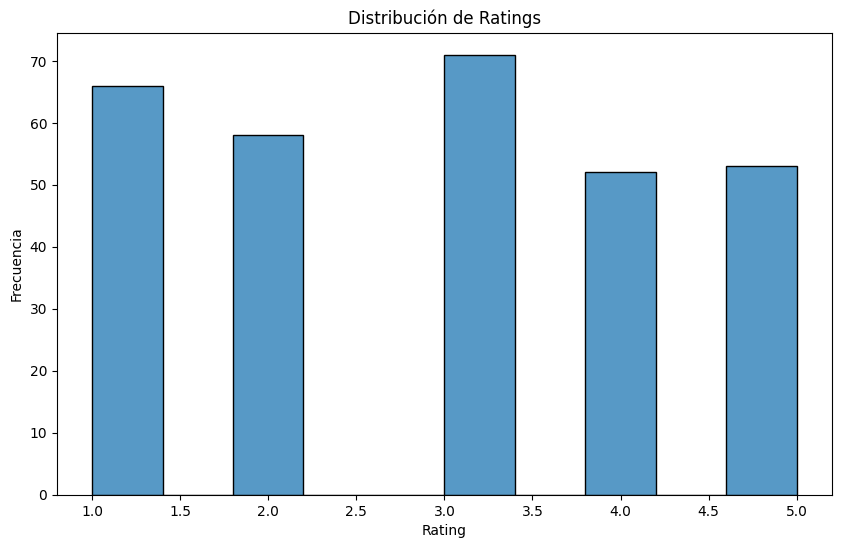

In [9]:
## Grafica de distribución de ratings
plt.figure(figsize=(10,6))
sns.histplot(df['rating'], bins=10)
plt.title('Distribución de Ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()

Se confirma la hipótesis acerca de la distribución de los datos. la mayor concentración de datos se da alrededor de 2.89 y el resto de valores se encuentran dispersos dentro del rango

In [10]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
print("\nTipo de dato timestamp:", df["timestamp"].dtype)


Tipo de dato timestamp: datetime64[ns]


In [11]:
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')
df['year_month'] = df['timestamp'].dt.to_period('M')
df['year'] = df['timestamp'].dt.to_period('Y')


In [12]:
mes_rnk = df.groupby('year_month')['rating'].mean()

In [13]:
df.groupby("year_month").size().sort_values(ascending=True)

year_month
2024-09    18
2024-11    23
2024-02    24
2024-01    27
2024-07    27
2024-10    27
2024-06    27
2024-03    29
2024-05    30
2024-04    34
2024-08    34
Freq: M, dtype: int64

<Axes: title={'center': 'Promedio de Ratings por Día'}, xlabel='timestamp'>

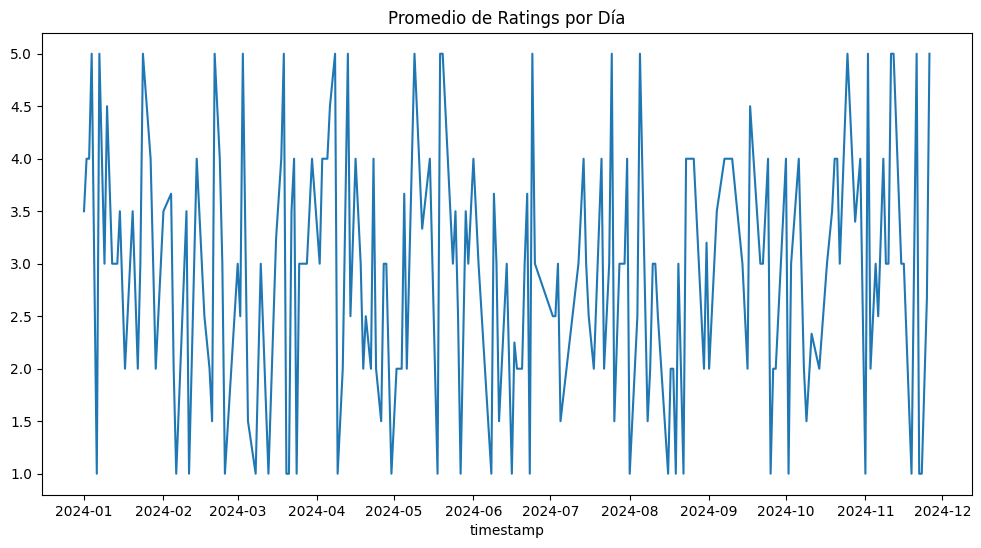

In [14]:
df.groupby(df["timestamp"].dt.date)["rating"].mean().plot(figsize=(12,6), title="Promedio de Ratings por Día")

C:\Users\juanc\AppData\Local\Temp\ipykernel_23344\520666714.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df.set_index("timestamp")["rating"].resample("M").mean()
C:\Users\juanc\AppData\Local\Temp\ipykernel_23344\520666714.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.asfreq("M")


Número de observaciones: 11
timestamp
2024-01-31    3.333333
2024-02-29    2.833333
2024-03-31    2.620690
2024-04-30    2.970588
2024-05-31    3.166667
2024-06-30    2.666667
2024-07-31    2.740741
2024-08-31    2.529412
2024-09-30    3.000000
2024-10-31    3.000000
2024-11-30    3.086957
Freq: ME, Name: rating, dtype: float64


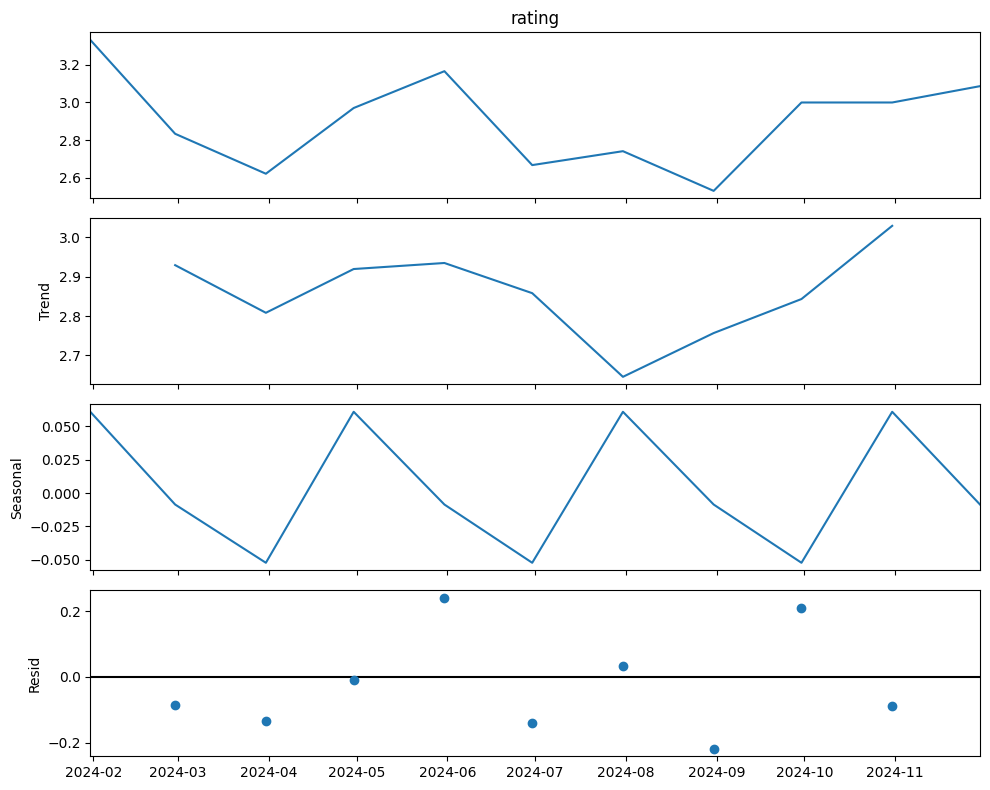

In [15]:

ts = df.set_index("timestamp")["rating"].resample("M").mean()
print("Número de observaciones:", len(ts))
print(ts)
ts = ts.asfreq("M")
decompose = seasonal_decompose(ts, model="additive", period=3)

fig = decompose.plot()
fig.set_size_inches(10, 8) 
plt.tight_layout()
plt.show()

* Se realiza un analisis temporal con el cual se pueda identificar alguna tendencia respecto a las fechas acerca de los puntajes que se obtengan.<br>
* Se puede evidenciar que a lo largo del tiempo se presenta una estacionalidad trimestral donde suben y bajan los puntajes de rating. Puede relacionarse con el fin de promociones por estación. <br>
* Además de la información obtenida en el grafico de tendencias donde se aprecia una caida en gral en los ratings a partir de Marzo y una excelente recuperación a partir de agosoto. Correlacionar con cambios de politica o estrategias de marketing implementadas  

In [16]:
ranking_prod=df.groupby('product_title').size().sort_values(ascending=False).head(10).copy()

In [17]:
ranking_prod

product_title
Barra de Sonido X200       21
Control de TV Universal    21
Tablet Vision 10           21
Microondas SteelHeat       19
Auriculares Pro X          18
Smart TV 50 UHD            18
Mini Drone AirLite         17
Disco SSD 1TB              16
Silla Gamer Pro            15
Smartwatch Fit 2           15
dtype: int64

Productos más vendidos

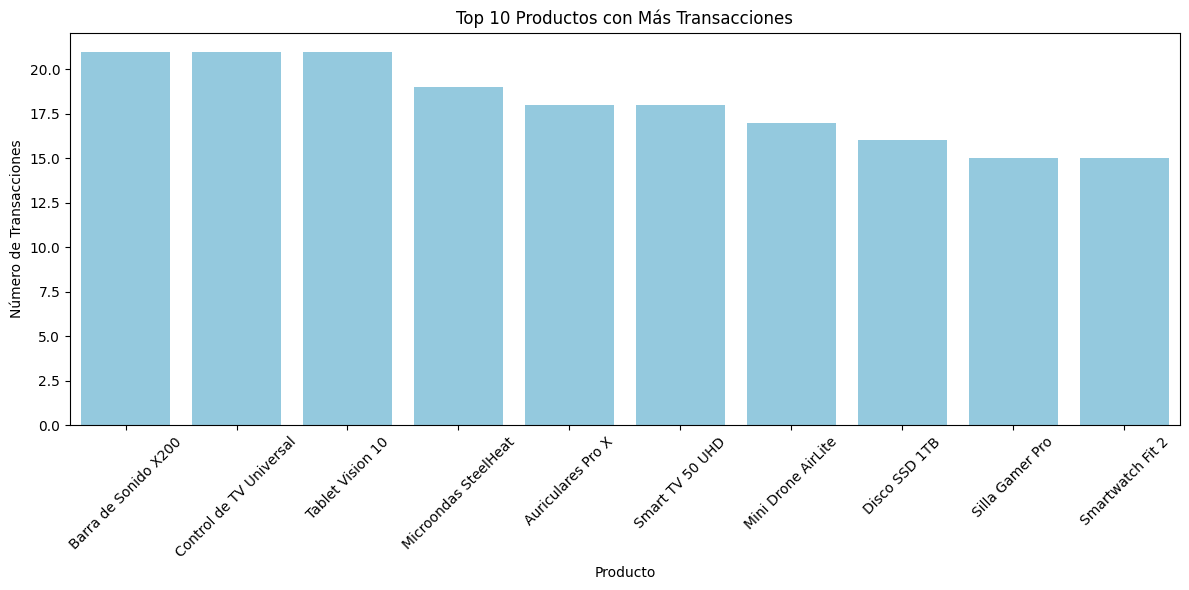

In [18]:
plt.figure(figsize=(12,6))
sns.barplot(x=ranking_prod.index, y=ranking_prod.values, color='skyblue')
plt.title('Top 10 Productos con Más Transacciones')
plt.xlabel('Producto')
plt.ylabel('Número de Transacciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:

ranking_ult_mes=df[df['year_month']==df['year_month'].max()].groupby('product_title').size().sort_values(ascending=False).head(10).copy()
ranking_ult_mes

product_title
Barra de Sonido X200       3
Smart TV 50 UHD            3
Control de TV Universal    2
Mini Drone AirLite         2
Smartwatch Fit 2           2
Laptop Pro 15              2
Auriculares Pro X          1
Disco SSD 1TB              1
Cámara ProShot 12          1
Cargador Turbo 30W         1
dtype: int64

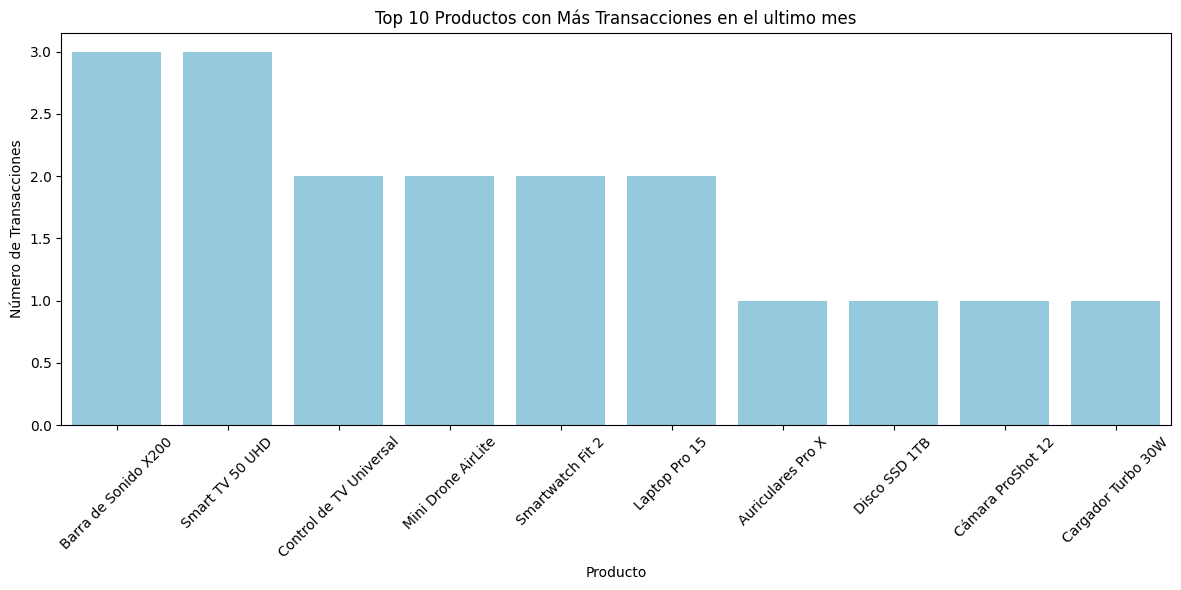

In [20]:
plt.figure(figsize=(12,6))
sns.barplot(x=ranking_ult_mes.index, y=ranking_ult_mes.values, color='skyblue')
plt.title('Top 10 Productos con Más Transacciones en el ultimo mes')
plt.xlabel('Producto')
plt.ylabel('Número de Transacciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Preparación para modelos

#### Unificación de textos

In [21]:
df

,user_id,product_id,product_title,product_description,rating,timestamp,year_month,year
0,U002,P002,Laptop Pro 15,Laptop de alto rendimiento con 16GB RAM y proc...,2,2024-04-19 12:37:33,2024-04,2024
1,U028,P017,Mini Drone AirLite,Drone portátil con cámara HD y estabilización ...,3,2024-04-14 05:39:40,2024-04,2024
2,U030,P004,Smartwatch Fit 2,Reloj inteligente con seguimiento deportivo y ...,5,2024-02-16 10:03:03,2024-02,2024
3,U006,P013,Control de TV Universal,Control universal compatible con múltiples mar...,2,2024-04-17 15:02:30,2024-04,2024
4,U015,P016,Horno Eléctrico Max,Horno eléctrico con capacidad de 45L.,1,2024-08-09 15:56:08,2024-08,2024
...,...,...,...,...,...,...,...,...
295,U019,P013,Control de TV Universal,Control universal compatible con múltiples mar...,1,2024-11-05 17:06:44,2024-11,2024
296,U018,P007,Silla Gamer Pro,Silla ergonómica con soporte lumbar ajustable.,1,2024-02-20 11:43:57,2024-02,2024
297,U019,P014,Mouse Gamer Viper,Mouse ergonómico con sensor óptico de alta pre...,3,2024-11-16 03:27:22,2024-11,2024
298,U023,P007,Silla Gamer Pro,Silla ergonómica con soporte lumbar ajustable.,4,2024-07-21 15:16:40,2024-07,2024


In [22]:
df['product']=df['product_title'] + " | " + df['product_description']


In [23]:
df_cant=df[['product_id','product']].drop_duplicates()

In [24]:
#asignar ventas por producto y hacer match con product_id
counts = df['product_id'].value_counts()                      # Serie: index=product_id, value=conteo
df_cant['ventas'] = df_cant['product_id'].map(counts).fillna(0).astype(int)

In [25]:
df_cant.sort_values(by='ventas', ascending=False).head(10)

,product_id,product,ventas
3,P013,Control de TV Universal | Control universal co...,21
33,P020,Tablet Vision 10 | Tablet HD de 10 pulgadas id...,21
23,P009,Barra de Sonido X200 | Sistema de sonido envol...,21
43,P019,Microondas SteelHeat | Microondas de 23L con m...,19
20,P008,Smart TV 50 UHD | Televisor 4K con soporte HDR...,18
5,P001,Auriculares Pro X | Auriculares inalámbricos c...,18
1,P017,Mini Drone AirLite | Drone portátil con cámara...,17
22,P015,Disco SSD 1TB | Unidad de estado sólido NVMe d...,16
4,P016,Horno Eléctrico Max | Horno eléctrico con capa...,15
2,P004,Smartwatch Fit 2 | Reloj inteligente con segui...,15


In [26]:
df_cant["text"] = df_cant['product']

product_texts = (
    df_cant[["product_id", "text"]]
    .drop_duplicates("product_id")
    .set_index("product_id")["text"]
    .to_dict()
)

Generar embeddings

In [ ]:

client =OpenAI(api_key="XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX") ## Reemplazar el API Key aquí


def embed_text(text):
    res = client.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    return np.array(res.data[0].embedding, dtype=np.float32)

embeddings = {}
for pid, text in product_texts.items():
    embeddings[pid] = embed_text(text)

# Convertir a matriz para FAISS
product_ids = list(embeddings.keys())
emb_matrix = np.vstack([embeddings[pid] for pid in product_ids])

np.save("C:/Users/juanc/OneDrive/Escritorio/Prueba/data/embeddings.npy", emb_matrix)
np.save("C:/Users/juanc/OneDrive/Escritorio/Prueba/data/product_ids.npy", np.array(product_ids))

Se cargan los embeddings en Faiss

In [28]:
emb_matrix = np.load("C:/Users/juanc/OneDrive/Escritorio/Prueba/data/embeddings.npy")
product_ids = np.load("C:/Users/juanc/OneDrive/Escritorio/Prueba/data/product_ids.npy")

d = emb_matrix.shape[1]  
index = faiss.IndexFlatL2(d)
index.add(emb_matrix)

faiss.write_index(index, "C:/Users/juanc/OneDrive/Escritorio/Prueba/data/faiss.index")

In [29]:
df_prod = (
    df_cant[["product_id", "product", "ventas"]]
    .drop_duplicates("product_id")
    .reset_index(drop=True)
)

df_prod.to_csv("C:/Users/juanc/OneDrive/Escritorio/Prueba/data/catalogo_productos.csv", index=False)

F(x) de busqueda semantica

In [30]:
def embed_query(text):
    out = client.embeddings.create(
        model="text-embedding-3-small",
        input=text,
    )
    return np.array(out.data[0].embedding, dtype=np.float32).reshape(1, -1)

index = faiss.read_index("C:/Users/juanc/OneDrive/Escritorio/Prueba/data/faiss.index")
df_prod = pd.read_csv("C:/Users/juanc/OneDrive/Escritorio/Prueba/data/catalogo_productos.csv")

Recomendador

In [31]:
def retrieve_products(query, k_semantic=10, k_final=5):
 
    q_emb = embed_query(query)


    distances, idxs = index.search(q_emb, k_semantic)


    candidatos = df_prod.iloc[idxs[0]].copy()
    candidatos["distancia"] = distances[0]
    candidatos["ventas"] = candidatos["ventas"].astype(int)


    candidatos = candidatos.sort_values(
        by=["ventas", "distancia"],
        ascending=[False, True]
    ).head(k_final)

    return candidatos

F(x) RAG

In [32]:
def rag_recommendation(query, k=5):
    
    retrieved = retrieve_products(query, k_final=k)

   
    context_str = "\n\n".join(
        f"Producto: {row['product']}.\nVentas: {row['ventas']}."
        for _, row in retrieved.iterrows()
    )

    prompt = f"""
Eres un asistente experto en recomendaciones.

El usuario busca: "{query}"

Aquí tienes los productos más relevantes del catálogo:

{context_str}

Con esta información:
1. Explica por qué estos productos son adecuados.
2. Haz una recomendación clara y con lenguaje simple.
3. Ordena los productos desde el más recomendado.
4. Mantén un tono profesional pero amable.
"""

    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "Eres un recomendador experto de productos."},
            {"role": "user", "content": prompt}
        ]
    )

    texto = resp.choices[0].message.content

    return retrieved, texto

In [33]:
productos, respuesta = rag_recommendation("audífonos inalámbricos")


In [34]:
print(respuesta)

¡Hola! Entiendo que estás buscando audífonos inalámbricos, así que permíteme ayudarte a elegir el producto adecuado. A continuación, te presento algunas opciones del catálogo que podrían interesarte, junto con razones de por qué podrían ser adecuadas:

1. **Auriculares Pro X**: Estos auriculares inalámbricos son la opción más recomendada para ti. Cuentan con cancelación de ruido, lo que te permitirá disfrutar de tu música o podcasts sin interrupciones externas. Además, su batería ofrece hasta 40 horas de uso, lo que es excelente para largas jornadas o viajes. 

2. **Barra de Sonido X200**: Aunque no son exactamente audífonos, este sistema de sonido envolvente compacto puede complementar tu experiencia auditiva en casa. Si disfrutas ver películas o escuchar música en tu televisor, esta barra de sonido mejorará notablemente la calidad del audio.

3. **Smart TV 50 UHD**: Similar a la barra de sonido, este televisor permite una experiencia de entretenimiento visual superior. Sin embargo, n

### Metricas

In [35]:
def evaluate_precision_recall_at_k(test_cases, k=3):
    precisions = []
    recalls = []

    for case in test_cases:
        query = case["query"]
        relevantes = set(case["relevantes"])

        # Obtener recomendaciones del modelo
        recs = retrieve_products(query, k_final=k)
        pred_ids = list(recs["product_id"])

        # Calcular hits
        hits = sum(1 for pid in pred_ids if pid in relevantes)

        # Precision@K
        precision_k = hits / k if k > 0 else 0.0

        # Recall@K
        recall_k = hits / len(relevantes) if len(relevantes) > 0 else 0.0

        precisions.append(precision_k)
        recalls.append(recall_k)

        print(f"Query: {query}")
        print(f"  Relevantes : {relevantes}")
        print(f"  Predichos  : {pred_ids}")
        print(f"  Hits       : {hits}")
        print(f"  Precision@{k}: {precision_k:.2f}")
        print(f"  Recall@{k}   : {recall_k:.2f}")
        print("-" * 40)

    # Promedio global
    mean_precision = sum(precisions) / len(precisions) if precisions else 0.0
    mean_recall = sum(recalls) / len(recalls) if recalls else 0.0

    print(f"\nPrecision@{k} promedio: {mean_precision:.2f}")
    print(f"Recall@{k} promedio   : {mean_recall:.2f}")

    return mean_precision, mean_recall

Se define un conjunto como la "verdad"

In [38]:
test_cases = [
    {
        "query": "audífonos inalámbricos bluetooth",
        "relevantes": ["P001", "P009"],  # auriculares + barra de sonido (audio)
    },
    {
        "query": "televisor smart tv 4k",
        "relevantes": ["P008"],  # Smart TV 50 UHD
    },
    {
        "query": "tablet para ver películas y navegar",
        "relevantes": ["P020"],  # Tablet Vision 10
    },
    {
        "query": "barra de sonido para televisor",
        "relevantes": ["P009"],  # Barra de Sonido X200
    },
    {
        "query": "control remoto universal para varios televisores",
        "relevantes": ["P013"],  # Control TV Universal
    },
    {
        "query": "drone con cámara hd para grabar videos",
        "relevantes": ["P017"],  # Mini Drone AirLite
    },
    {
        "query": "accesorios para televisión",
        "relevantes": ["P009", "P013", "P008"],  # audio + control + TV
    },
    {
        "query": "equipo de sonido para cine en casa",
        "relevantes": ["P009", "P001"],  # barra de sonido + audífonos
    },
]

In [39]:
evaluate_precision_recall_at_k(test_cases, k=3)

Query: audífonos inalámbricos bluetooth
  Relevantes : {'P009', 'P001'}
  Predichos  : ['P009', 'P013', 'P001']
  Hits       : 2
  Precision@3: 0.67
  Recall@3   : 1.00
----------------------------------------
Query: televisor smart tv 4k
  Relevantes : {'P008'}
  Predichos  : ['P013', 'P020', 'P019']
  Hits       : 0
  Precision@3: 0.00
  Recall@3   : 0.00
----------------------------------------
Query: tablet para ver películas y navegar
  Relevantes : {'P020'}
  Predichos  : ['P020', 'P008', 'P017']
  Hits       : 1
  Precision@3: 0.33
  Recall@3   : 1.00
----------------------------------------
Query: barra de sonido para televisor
  Relevantes : {'P009'}
  Predichos  : ['P009', 'P013', 'P020']
  Hits       : 1
  Precision@3: 0.33
  Recall@3   : 1.00
----------------------------------------
Query: control remoto universal para varios televisores
  Relevantes : {'P013'}
  Predichos  : ['P013', 'P020', 'P009']
  Hits       : 1
  Precision@3: 0.33
  Recall@3   : 1.00
-----------------

(0.3333333333333333, 0.6458333333333334)

### Plan de evaluación y monitoreo

##### Detección de degradación del modelo

* Se deben realizar evaluaciones periodicas en donde se tengan en cuenta las medidas antes propuestas. Se debe estar alerta ante una caida de métricas lo cual podría indicar que posiblemente los usuarios ahora estan buscando productos nuevos que no estén presentes en el corpus del catalogo.
* Monitorear el aumento de latencia en las peticiones del servicio.

#### ¿Cuando re entrenar?

* Se debe re-calcular los embeddings cuando se agreguen productos nuevos.(Solo del producto nuevo).
* Cuando las descripciones de los productos cambian, siguiendo el primer lineamiento proporcionado en estas recomendaciones.
* Cuando las metricas del algoritmo caigan más de lo normal. 

Se propone persistir los productos en una DB en donde se pueda relacionar cada uno con la ultima fecha de actualización y la ultima fecha en donde se realizó el recalculo de los embedings.  El objetivo es realizar un seguimiento más exhaustivo que se complementaría con un pipeline que automatice de manera calendarizada y a demanda el control de las actualizaciones de los embedings. 